# Assignment 02 - CIFAR10 Image Classification


In this assignment your team will design a fully connected neural network and a convolutional neural network (CNN) models for classifiying the CIFAR10 image dataset. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. I expect you to try different configurations (models, train/validtion split, etc.), but for your submission, leave just the best fully connected and the best CNN models.
    - Name the notebook as enel645__assignment02__team_(team number).ipynb
2. The weights of your best fully connected neural network model and your best CNN model 
    - Name the weights files as team__(team number)__FCN.h5 (fully connected model) and team__(team number)__CNN.h5 (CNN model)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page.
    
We will be using the CIFAR10 dataset. The dataset alerady comes with a test set and you shouldn't change it. It is up to you to determine how to split your development set into training and validation sets. Use variable names consistent with the variables pre-filled in this document.


You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on (more details in the rubric):

1. Code execution - 20% 
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%


In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import sys

## 1. Load your data

In [2]:
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

print(X_dev.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## 2. Explore your data 

Showing 10 samples from dev set

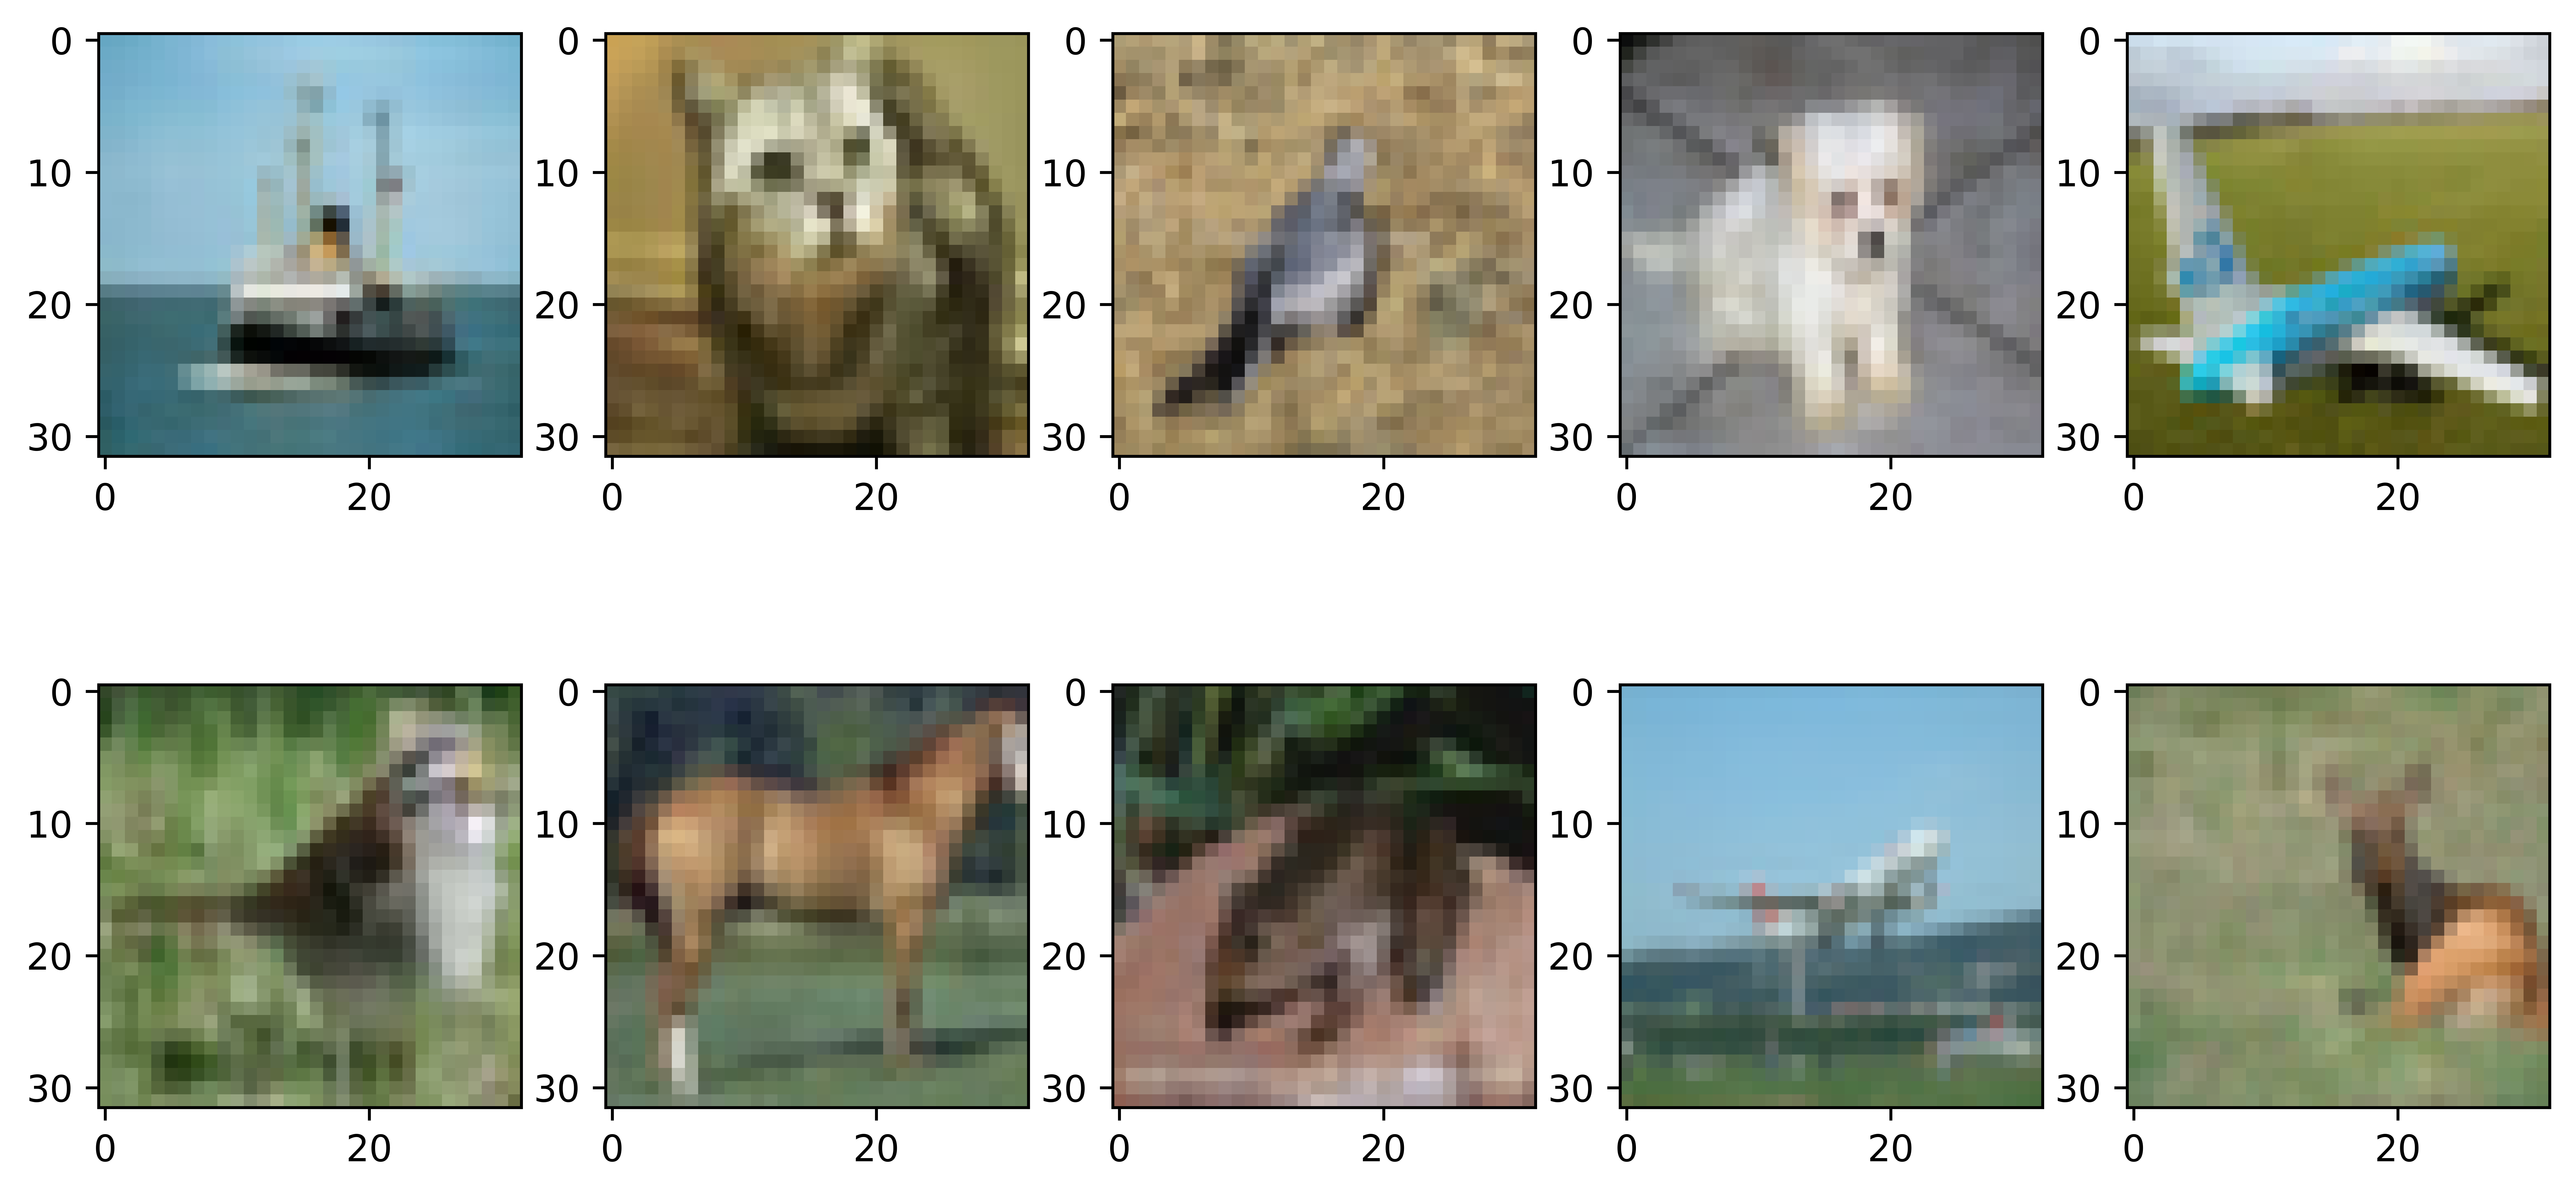

In [3]:
plt.figure(figsize=(12, 6), dpi=1000)
indexes = np.arange(len(X_dev))
np.random.shuffle(indexes)
for idx in range(10):
  plt.subplot(2, 5, idx + 1)
  plt.imshow(X_dev[indexes[idx]])
plt.show()

#Splitting dev set into train/val set

In [4]:
splitter = int(len(X_dev) * .8) #= splitting point of train/val set

X_train = X_dev[indexes[:splitter]]
Y_train = Y_dev[indexes[:splitter]]

X_val = X_dev[indexes[splitter:]]
Y_val = Y_dev[indexes[splitter:]]

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)

X_train: (40000, 32, 32, 3)
X_val: (10000, 32, 32, 3)


## 3. Represent your labels using one hot encoding

In [5]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)

print("Y_train",  Y_train[:3])
print("Y_train_oh:",  Y_train_oh[:3])
print("Y_val",  Y_val[:3])
print("Y_val_oh:",  Y_val_oh[:3])
print("Y_test",  Y_test[:3])
print("Y_test_oh:",  Y_test_oh[:3])


#Scaling outputs
X_train_sc = X_train
X_val_sc = X_val
X_test_sc = X_test


Y_train [[8]
 [3]
 [2]]
Y_train_oh: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
Y_val [[2]
 [5]
 [1]]
Y_val_oh: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Y_test [[3]
 [8]
 [8]]
Y_test_oh: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


## 4. Data scaling and Data augmentation

In [6]:
# Experiment with different data scaling methods

scaling_mode = 2  #= 0: disabled, 1: min-max normalization, 2: standardization

X_train = X_train_sc 
X_val = X_val_sc 
X_test = X_test_sc 

if scaling_mode == 1: 
  x_train_min = X_train.min()
  x_train_max = X_train.max()
  X_train = ( X_train - x_train_min ) / (x_train_max - x_train_min)
  x_val_min = X_val.min()
  x_val_max = X_val.max()
  X_val = ( X_val - x_val_min ) / (x_val_max - x_val_min)
  x_test_min = X_test.min()
  x_test_max = X_test.max()
  X_test = ( X_test - x_test_min ) / (x_test_max - x_test_min)
elif scaling_mode == 2:
  x_train_mean = X_train.mean()
  x_train_std = X_train.std()
  print(x_train_mean, x_train_std)
  X_train = ( X_train - x_train_mean ) / x_train_std
  X_val = ( X_val - x_train_mean ) / x_train_std
  X_test = ( X_test - x_train_mean ) / x_train_std
  

    





120.70078399251302 64.15630106724853


In [7]:
# Create your data augmentation object to improve training
# set your batch size

batch_size = 32
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":50,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.1, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'nearest',\
               "cval": 0}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size)

[[[[0.4084177  0.91258055 0.80862296]
   [0.43133688 0.9370977  0.8349341 ]
   [0.4441792  0.96161485 0.8612452 ]
   ...
   [0.6177889  0.88896656 0.71273386]
   [0.56590265 0.9026959  0.75226605]
   [0.5345951  0.93589544 0.8328412 ]]

  [[0.36535326 0.8764369  0.7698347 ]
   [0.3962376  0.90095407 0.7961458 ]
   [0.42192227 0.92547125 0.82245696]
   ...
   [0.57714033 0.8940111  0.7334127 ]
   [0.5266499  0.9357694  0.82664895]
   [0.5682724  0.93642974 0.8590885 ]]

  [[0.30920127 0.8406012  0.73137695]
   [0.34708315 0.86481047 0.7573576 ]
   [0.38405755 0.88932765 0.7836687 ]
   ...
   [0.529507   0.9308237  0.81332695]
   [0.5603273  0.9363037  0.8528962 ]
   [0.5843017  0.93997955 0.8873667 ]]

  ...

  [[0.27401862 0.5229079  0.5140532 ]
   [0.32358274 0.55528533 0.5727677 ]
   [0.34696606 0.6010365  0.63959455]
   ...
   [0.5767039  0.7045438  0.96541184]
   [0.55422986 0.64461297 0.8481558 ]
   [0.5218449  0.5846821  0.7412416 ]]

  [[0.32118753 0.54797757 0.5573185 ]
   [0.3

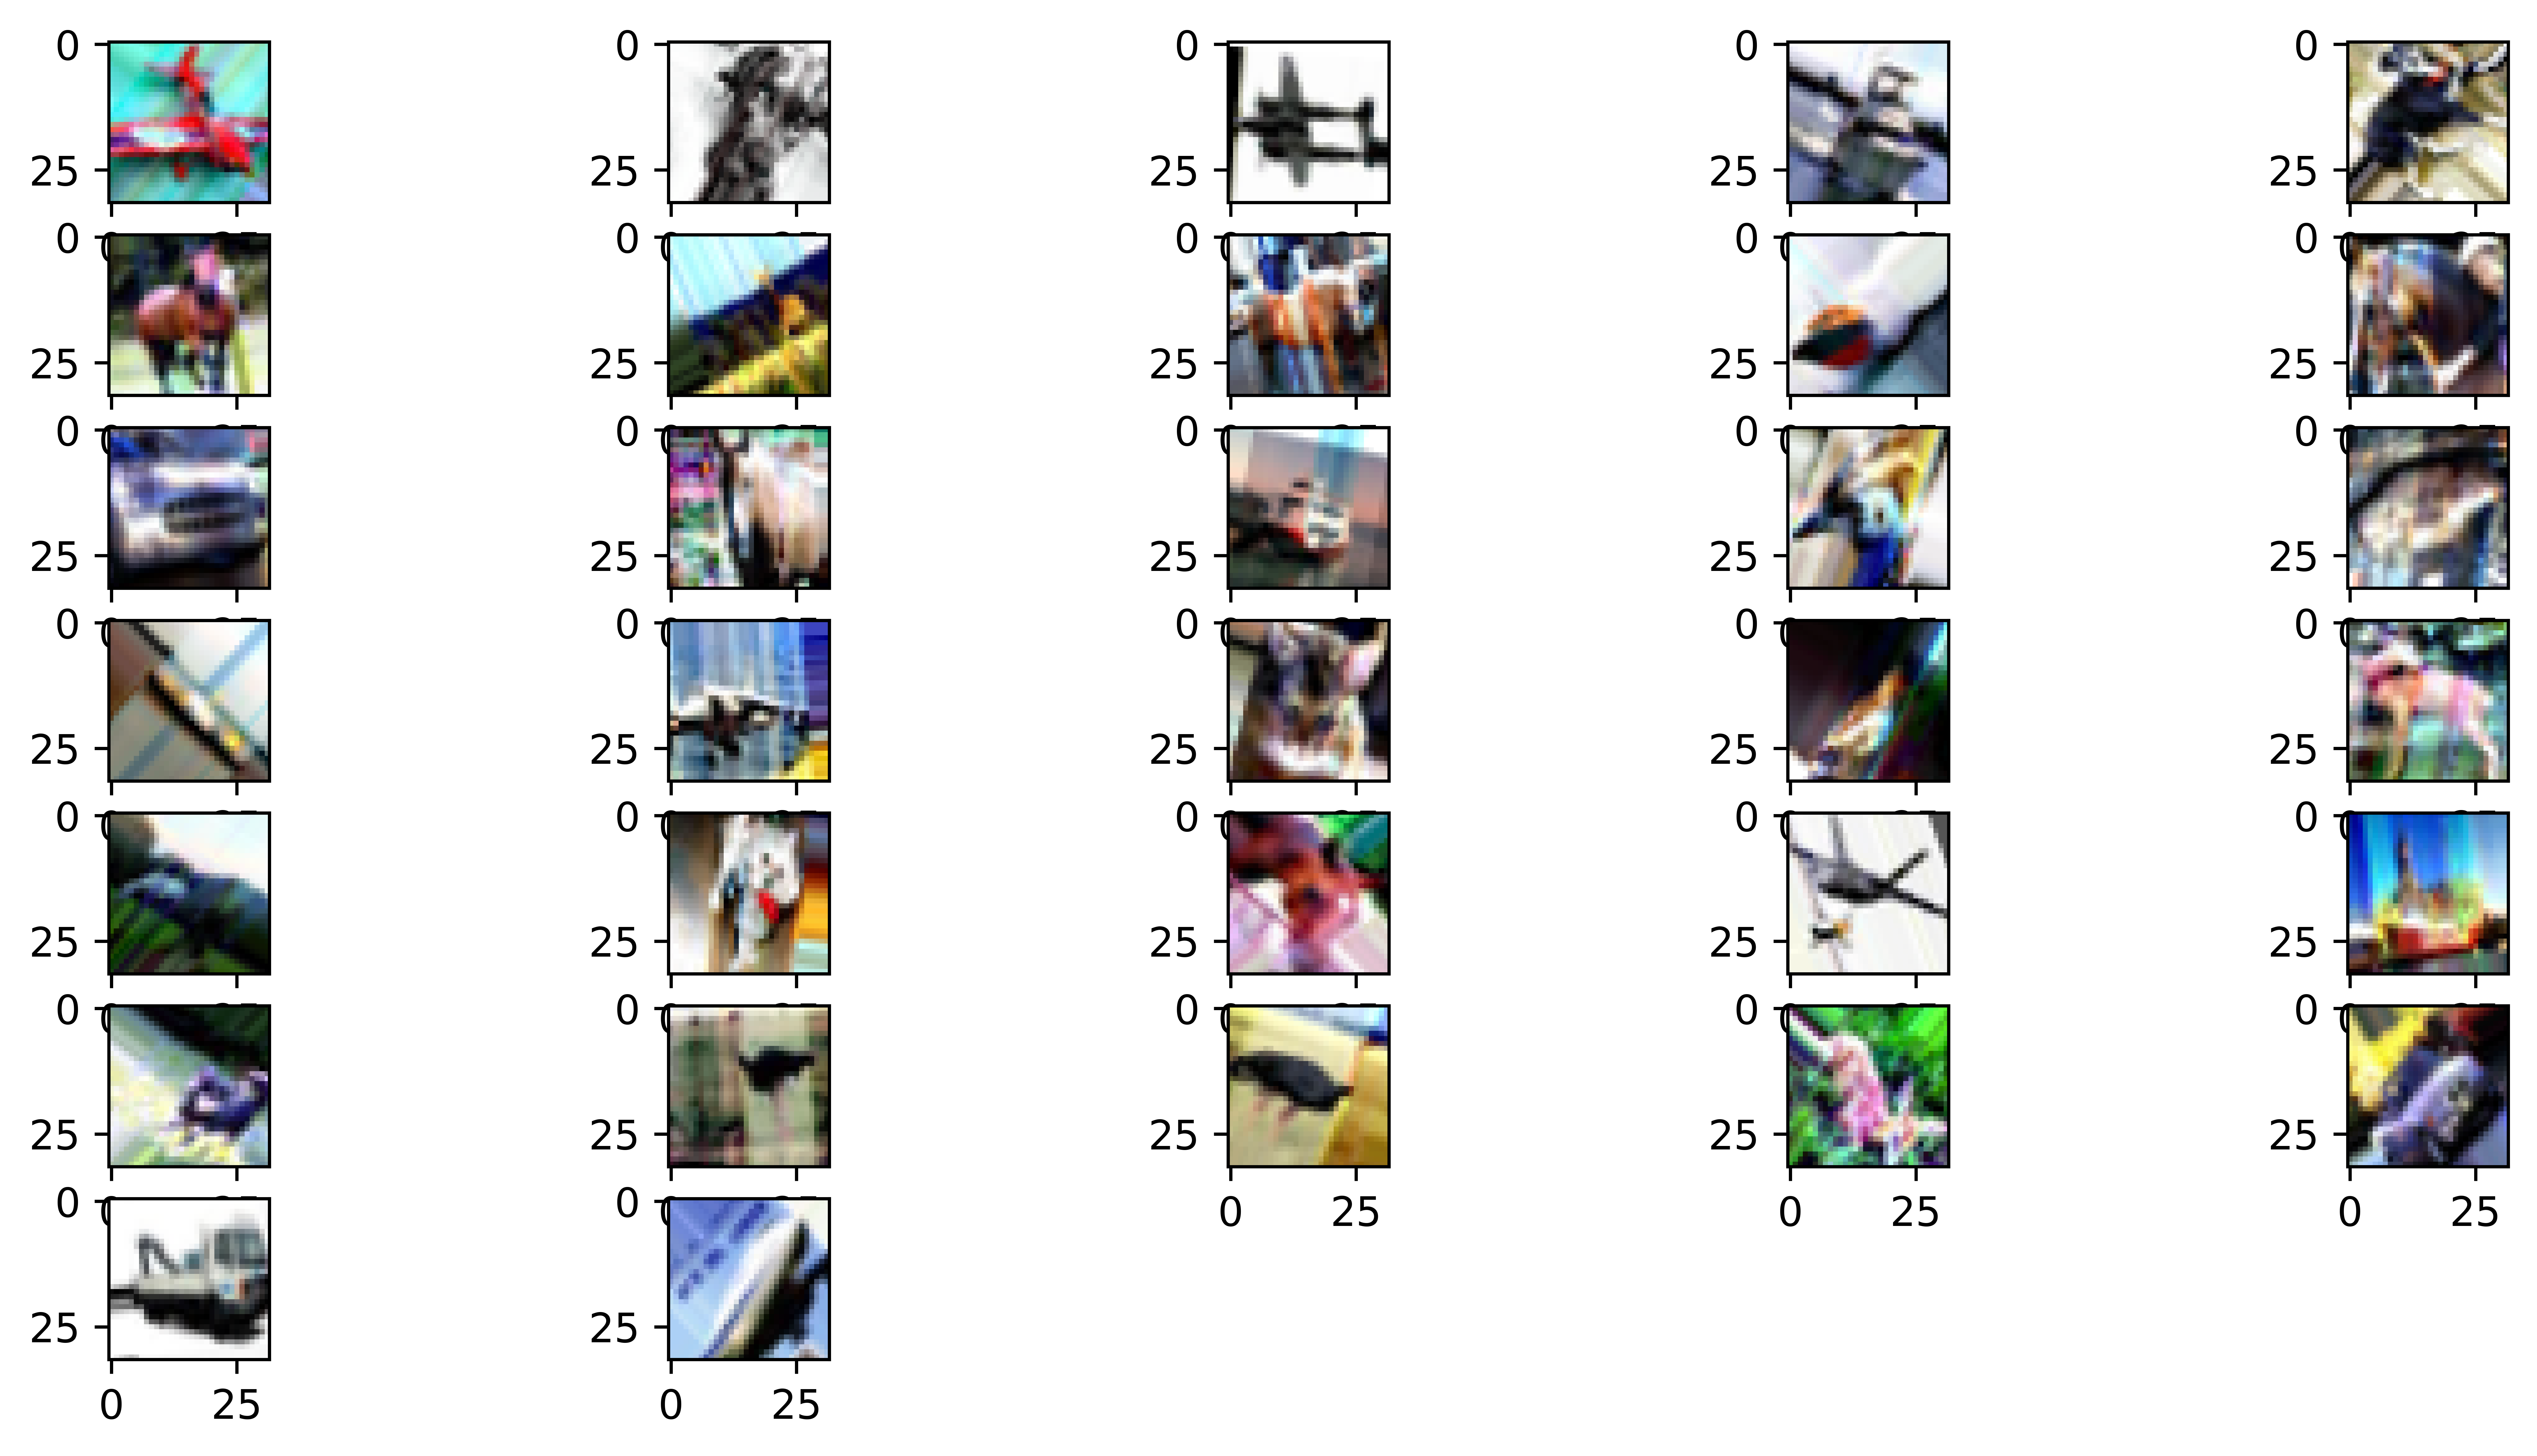

SystemExit: Error message

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
# plt.figure(figsize=(12, 6), dpi=1000)
# for i in range(10):
#   plt.subplot(2, 5, i + 1)
#   plt.imshow(X_train[i])

# plt.show()


plt.figure(figsize=(12, 6), dpi=1000)
Xbatch,Ybatch = train_flow.__getitem__(1)
Xbatch_min = Xbatch.min(axis=1, keepdims=True)
Xbatch_max = Xbatch.max(axis=1, keepdims=True)
print(Xbatch)
# Xbatch = ( Xbatch - Xbatch_min ) / (Xbatch_max - Xbatch_min)
for ii in range(batch_size):
    plt.subplot(7,5,ii+1)
    plt.imshow(Xbatch[ii].reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
               
               
plt.show()

# sys.exit("Error message")





## Fully Connected Model

## 5. Define your  model, cost function, optimizer, learning rate

In [25]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_fully_connected(ishape = (32,32,3),k = 10, lr = 1e-4):
    model_input = tf.keras.layers.Input(shape = ishape)
    model_input_flatten = tf.keras.layers.Flatten()(model_input)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(model_input_flatten)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model
    


In [26]:
model = my_model_fully_connected()
print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________
None


## 6. Define your callbacks (save your model, patience, etc.)

In [27]:
model_name_fcn = "team_(team number)_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_fcn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Train your model

In [28]:
# train your model - decide for how many epochs
model.fit(X_train,Y_train_oh,batch_size = 32, epochs = 1000, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val_oh))

Epoch 1/1000
1250/1250 [==============================] - 17s 4ms/step - loss: 2.1966 - accuracy: 0.2509 - val_loss: 1.8917 - val_accuracy: 0.3431
Epoch 2/1000
1250/1250 [==============================] - 2s 1ms/step - loss: 1.8593 - accuracy: 0.3566 - val_loss: 1.8254 - val_accuracy: 0.3698
Epoch 3/1000
1250/1250 [==============================] - 1s 1ms/step - loss: 1.8148 - accuracy: 0.3736 - val_loss: 1.8027 - val_accuracy: 0.3807
Epoch 4/1000
1250/1250 [==============================] - 1s 1ms/step - loss: 1.7751 - accuracy: 0.3894 - val_loss: 1.7860 - val_accuracy: 0.3862
Epoch 5/1000
1250/1250 [==============================] - 1s 1ms/step - loss: 1.7609 - accuracy: 0.3932 - val_loss: 1.7717 - val_accuracy: 0.3933
Epoch 6/1000
1250/1250 [==============================] - 1s 1ms/step - loss: 1.7319 - accuracy: 0.4056 - val_loss: 1.7677 - val_accuracy: 0.3960
Epoch 7/1000
1250/1250 [==============================] - 1s 1ms/step - loss: 1.7226 - accuracy: 0.4119 - val_loss: 1.7597 

Epoch 57/1000
1250/1250 [==============================] - 2s 1ms/step - loss: 1.6372 - accuracy: 0.4466 - val_loss: 1.7289 - val_accuracy: 0.4098
Epoch 58/1000
1250/1250 [==============================] - 2s 1ms/step - loss: 1.6418 - accuracy: 0.4464 - val_loss: 1.7287 - val_accuracy: 0.4110
Epoch 59/1000
1250/1250 [==============================] - 2s 1ms/step - loss: 1.6375 - accuracy: 0.4479 - val_loss: 1.7289 - val_accuracy: 0.4095
Epoch 60/1000
1250/1250 [==============================] - 2s 1ms/step - loss: 1.6350 - accuracy: 0.4497 - val_loss: 1.7288 - val_accuracy: 0.4105
Epoch 61/1000
1250/1250 [==============================] - 2s 1ms/step - loss: 1.6317 - accuracy: 0.4483 - val_loss: 1.7287 - val_accuracy: 0.4104
Epoch 62/1000
1250/1250 [==============================] - 2s 1ms/step - loss: 1.6344 - accuracy: 0.4470 - val_loss: 1.7286 - val_accuracy: 0.4109
Epoch 63/1000
1250/1250 [==============================] - 2s 1ms/step - loss: 1.6339 - accuracy: 0.4472 - val_loss: 1

1250/1250 [==============================] - 2s 1ms/step - loss: 1.6205 - accuracy: 0.4571 - val_loss: 1.7285 - val_accuracy: 0.4104
Epoch 113/1000
1250/1250 [==============================] - 2s 1ms/step - loss: 1.6305 - accuracy: 0.4510 - val_loss: 1.7285 - val_accuracy: 0.4104
Epoch 114/1000
1250/1250 [==============================] - 2s 1ms/step - loss: 1.6411 - accuracy: 0.4464 - val_loss: 1.7285 - val_accuracy: 0.4104
Epoch 115/1000
1250/1250 [==============================] - 2s 1ms/step - loss: 1.6310 - accuracy: 0.4490 - val_loss: 1.7285 - val_accuracy: 0.4104
Epoch 116/1000
1250/1250 [==============================] - 2s 1ms/step - loss: 1.6277 - accuracy: 0.4514 - val_loss: 1.7285 - val_accuracy: 0.4104
Epoch 117/1000
1250/1250 [==============================] - 2s 1ms/step - loss: 1.6336 - accuracy: 0.4507 - val_loss: 1.7285 - val_accuracy: 0.4104
Epoch 118/1000
1250/1250 [==============================] - 2s 1ms/step - loss: 1.6393 - accuracy: 0.4466 - val_loss: 1.7285 - 

## 8. Test your model

313/313 [==============================] - 0s 937us/step - loss: 1.7305 - accuracy: 0.4034
90000000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

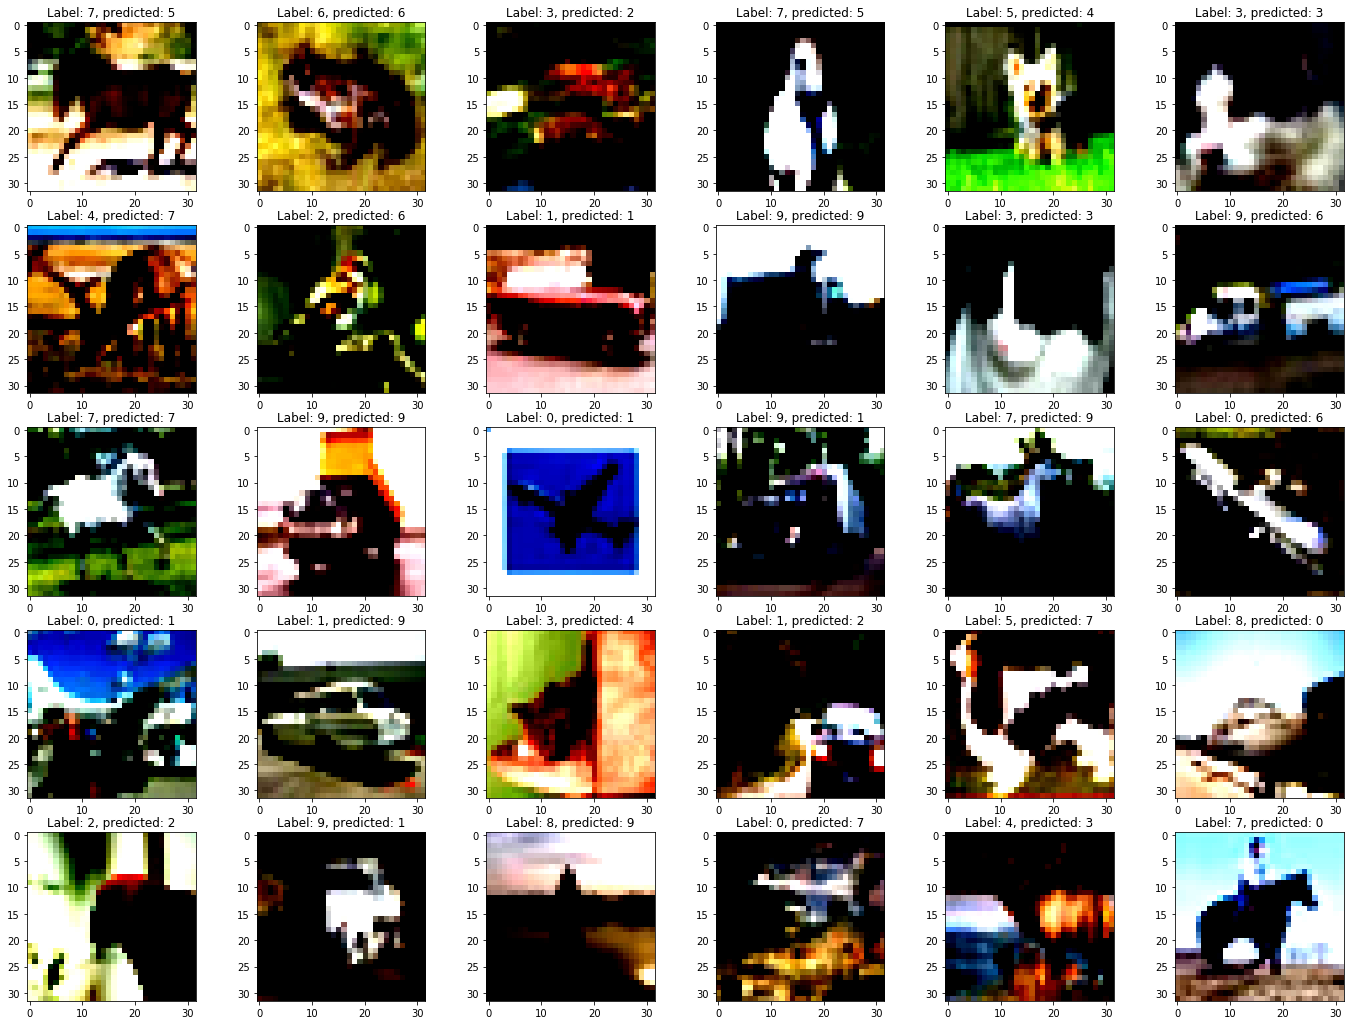

In [29]:
model.load_weights(model_name_fcn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

## Convolutional Model

## 5. Define your  model, cost function, optimizer, learning rate

In [ ]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_cnn():
    
    return

## 6. Define your callbacks (save your model, patience, etc.)

In [ ]:
model_name_cnn = "team_(team number)_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!

## 7. Train your model

In [ ]:
# train your model - decide for how many epochs

## 8. Test your model

In [ ]:
model.load_weights(model_name_cnn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Arya Stark** helped design the model and write the code for fully connected model (**score 3**)
- **Luke Skywalker** helped design helped to implement the data augmentation module (**score 3**)
- ...